# Indices Mosaic Notebook

Notebook to allow generation of mosaics using Indices - Indicies include Normalise Difference Vegetation Index (NDVI), Enhanced Vegetation Index (EVI), Normalised Difference Water Index (NDWI) and Normalised Difference Drought Index (NDDI). 


### Import Required Modules

In [1]:
# jupyteronly
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
import datacube

from matplotlib.cm import RdYlGn, Greens, Blues
import matplotlib.pyplot as plt

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
from pyproj import Proj, transform
from datacube.utils.cog import write_cog

import dask
from dask.distributed import Client

import odc.algo
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


In [3]:
#import datacube utilities
import datacube_utilities.data_access_api as dc_api  
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic, create_min_ndvi_mosaic
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.clean_mask import landsat_qa_clean_mask

### Initialise

In [4]:
#Jupyteronly
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='indices mosaic')

### Set Parameters for cube query

In [213]:
#parameters

#set start and end dates for time period of interest
#parameter display_name="Start Date" description='Start of time period window' datatype=date"
time_start = ('2019-1-1')
#parameter display_name="End Date" description='End of time period window' datatype=date"
time_end = ('2019-4-1')

#set resolution
#parameter display_name="Resolution" description="size of pixes" datatype="int"
res = (30)

#parameter display_name="Satellite" description="Satellite to use." datatype="string" options=["SENTINEL_2", "LANDSAT_4", "LANDSAT_5", "LANDSAT_7", "LANDSAT_8"],
platform = "LANDSAT_8"

#area of interest: load in as wkt
#parameter display_name="Area of Interest" description="The area for which the product is required." datatype="string" options=["SENTINEL_2", "LANDSAT_4", "LANDSAT_5", "LANDSAT_7", "LANDSAT_8"],
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON((177.43329863711836 -17.52948354640883,177.76975493594648 -17.52948354640883,177.76975493594648 -17.826499420595315,177.43329863711836 -17.826499420595315,177.43329863711836 -17.52948354640883))"

#parameter display_name="Mosaic Type" description="The type of mosaic." datatype="string" options=["max", "median", "min", "mean"],
mosaic_type = "median"

#parameter display_name="Indices Type" description="The type of Indices." datatype="string" options=["EVI", "NDVI, "NDDI", "NDVI", "NDWI_green", "NDWI_SWIR"],
indices = "NDWI_SWIR"

#parameter display_name="Coordinate Reference System" description="The EPSG code for the CRS, for Fiji this will be 3460." datatype="string" options=["3460", "3832"],
crs = "3460"


### Reformat parameters

In [214]:
#createAOI
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [215]:
# jupyteronly
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [216]:
#reprojection of AOI into input CRS and reformat
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:"+crs)
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3926662.098051653, 3934403.928509868)
(2024382.843073529, 2030659.4223828027)


## Translate inputs and load data

In [219]:
def relevantBands(indices):
    if indices == 'NDVI':
        ISMeasurements = ['nir', 'red']
    if indices == 'NDWI_Green':
        ISMeasurements = ['nir', 'green']
    if indices == 'NDWI_SWIR':
        ISMeasurements = ['nir', 'swir1']
    if indices == 'NDDI':
        ISMeasurements = ['nir', 'red', 'green']
    if indices == 'EVI':
        ISMeasurements = ['nir', 'red', 'blue']
    return(ISMeasurements)
    

In [220]:
allmeasurements = relevantBands(indices)

In [221]:
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls8_usgs_sr_scene'
elif platform in ["LANDSAT_7"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls7_usgs_sr_scene'
elif platform in ["LANDSAT_5"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls5_usgs_sr_scene'
elif platform in ["LANDSAT_4"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls4_usgs_sr_scene'
else:
    print("invalid platform")

In [222]:
#create resolution
resolution = (-res, res)

In [223]:
dask_chunks=dict(
    time = 10,
    x=2000, 
    y=2000
)

In [224]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': "EPSG:"+crs,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements,
    'dask_chunks' : dask_chunks,
    'crs': "EPSG:"+crs
}

In [225]:
#format dates
def createDate(inputDate):
    outputDate = datetime.strptime(inputDate, '%Y-%m-%d')
    outputDates = outputDate.date()
    return outputDates

dateStart = createDate(time_start)
dateEnd = createDate(time_end)
time_range = (dateStart, dateEnd)

In [226]:
loaded_ds = dc.load(
    time = time_range,
    **query
)

### Check if loads are valid

In [227]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [228]:
if is_dataset_empty(loaded_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

## Create cloud mask

In [229]:
if platform  in ["SENTINEL_2"]:
    clean_mask = (
        (loaded_ds.scene_classification == 4) | # clear
        (loaded_ds.scene_classification == 5) | 
        (loaded_ds.scene_classification == 7) | 
        (loaded_ds.scene_classification == 2) | 
        (loaded_ds.scene_classification == 6)  #water
    )
elif platform in ["LANDSAT_8"]:  
    clean_mask = (
        (loaded_ds.pixel_qa == 322)  | # clear
        (loaded_ds.pixel_qa == 386)  |
        (loaded_ds.pixel_qa == 834)  |
        (loaded_ds.pixel_qa == 898)  |
        (loaded_ds.pixel_qa == 1346) |
        (loaded_ds.pixel_qa == 324)  | # water
        (loaded_ds.pixel_qa == 388)  |
        (loaded_ds.pixel_qa == 836)  |
        (loaded_ds.pixel_qa == 900)  |
        (loaded_ds.pixel_qa == 1348)
    )
elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
    clean_mask = (
        (loaded_ds.pixel_qa == 66)  | # clear
        (loaded_ds.pixel_qa == 130)  |
        (loaded_ds.pixel_qa == 68)  | # water
        (loaded_ds.pixel_qa == 132)  
    )
else:
    print("invalid platform")
    
clean_mask

<xarray.DataArray 'pixel_qa' (time: 5, y: 259, x: 210)>
dask.array<or_, shape=(5, 259, 210), dtype=bool, chunksize=(5, 259, 210), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-01-13T22:06:28 ... 2019-03-18T22:...
  * y            (y) float64 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x            (x) float64 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
    spatial_ref  int32 3460

In [230]:
loaded_ds = loaded_ds.where(clean_mask)
loaded_ds

<xarray.Dataset>
Dimensions:      (time: 5, x: 210, y: 259)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-13T22:06:28 ... 2019-03-18T22:...
  * y            (y) float64 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x            (x) float64 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
    spatial_ref  int32 3460
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(5, 259, 210), meta=np.ndarray>
    swir1        (time, y, x) float64 dask.array<chunksize=(5, 259, 210), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(5, 259, 210), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

## Perform Mosaic

In [231]:
mosaic_function = {"median": create_median_mosaic,
                   "max": create_max_ndvi_mosaic,                   
                   "mean": create_mean_mosaic,
                   "min": create_min_ndvi_mosaic
                  }

In [232]:
mosaic_compositor = mosaic_function[mosaic_type]
mosaic_compositor

<function datacube_utilities.dc_mosaic.create_median_mosaic(dataset_in, clean_mask=None, no_data=nan, dtype=None, **kwargs)>

In [233]:
%%time
if mosaic_type == "median" or mosaic_type == "mean":
    mosaiced_composite = mosaic_compositor(loaded_ds, clean_mask=clean_mask)
else:
    mosaiced_composite = dask.delayed(mosaic_compositor)(loaded_ds, clean_mask = clean_mask)
mosaiced_composite

CPU times: user 69.5 ms, sys: 0 ns, total: 69.5 ms
Wall time: 85.4 ms


<xarray.Dataset>
Dimensions:      (x: 210, y: 259)
Coordinates:
  * y            (y) float64 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x            (x) float64 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
    spatial_ref  int32 3460
Data variables:
    nir          (y, x) float64 dask.array<chunksize=(259, 210), meta=np.ndarray>
    swir1        (y, x) float64 dask.array<chunksize=(259, 210), meta=np.ndarray>
    pixel_qa     (y, x) float64 dask.array<chunksize=(259, 210), meta=np.ndarray>

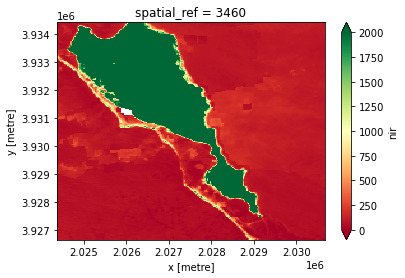

In [234]:
mosaiced_composite.nir.plot(vmin=0, vmax=2000, cmap = RdYlGn)

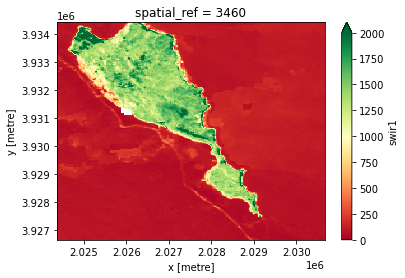

In [236]:
mosaiced_composite.swir1.plot(vmin=0, vmax=2000, cmap = RdYlGn)

In [237]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [238]:
#from within DCAL_Land_Change Script
def EVI(dataset):
    return 2.5*(dataset.nir - dataset.red)/(dataset.nir + 6.0*dataset.red - 7.5*dataset.blue + 1)

In [239]:
def NDWI_Green(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

In [240]:
def NDWI_SWIR(dataset):
    return (dataset.nir - dataset.swir1)/(dataset.nir + dataset.swir1)

In [241]:
def NDDI(dataset):
    aNDVI = NDVI(dataset)
    aNDWI = NDWI(dataset)
    return (aNDVI - aNDWI)/(aNDVI + aNDWI)

## Calculate Indices and Plot

In [242]:
indices_function = {"NDVI": NDVI, "NDWI_Green": NDWI_Green, "NDWI_SWIR": NDWI_SWIR, "EVI": EVI, "NDDI": NDDI}
indices_compositor = indices_function[indices]
indices_composite = indices_compositor(mosaiced_composite)
indices_composite

<xarray.DataArray (y: 259, x: 210)>
dask.array<truediv, shape=(259, 210), dtype=float64, chunksize=(259, 210), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x            (x) float64 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
    spatial_ref  int32 3460

In [243]:
# jupyteronly
#%%time
indices_composite = indices_composite.compute()

In [244]:
# jupyteronly
plt.figure(figsize = (8,8))
if indices in ["NDVI"]:
    indices_composite.plot(vmin=0, vmax=1, cmap = RdYlGn)
elif indices in ["NDWI"]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = RdYlGn)
elif indices in ["EVI"]:
    indices_composite.plot(vmin=0, vmax=3, cmap = RdYlGn)
elif indices in ["NDDI"]:
    indices_composite.plot(vmin=-30, vmax=30, cmap = RdYlGn)
else:
    print('indicies invalid')


indicies invalid


<Figure size 576x576 with 0 Axes>

In [245]:
#Sometimes clouds are not well masked, we can further mask invalid values by changnig all values which are less than -1 or greater than 1 when we are using normalised indices.

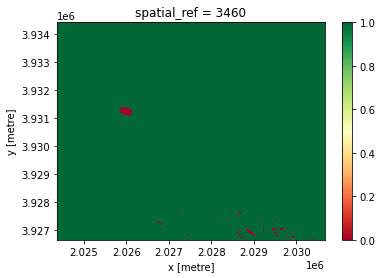

In [246]:
mask = ((indices_composite >= -1) & (indices_composite <= 1))
mask.plot(vmin=0, vmax=1, cmap = RdYlGn)

In [247]:
indices_composite_masked = indices_composite.where(mask != 0)

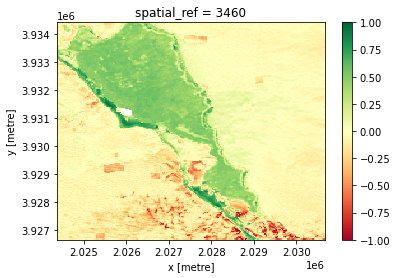

In [248]:
indices_composite_masked.plot(vmin=-1, vmax=1, cmap = RdYlGn)

### Exports

In [172]:
#Write as GeoTIFF
write_cog(geo_im=indices_composite,
          fname='indices_composite.tif',
          overwrite=True)

PosixPath('indices_composite.tif')

In [67]:
#write as Tiff
write_geotiff_from_xr('indices_composite.tiff', indices_composite, ["index"], crs="EPSG:"+crs, x_coord = 'x', y_coord = 'y')

In [33]:
#naming exports for ESRI to pick up
['indices_composite.tif']

['indices_composite_cog.tiff']

---